In [299]:
# imports 
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from pathlib import Path
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
import warnings
import pingouin as pg
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os
import glob
import random

 
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [300]:
import json
import os

# Load local config file
config_path = Path('config.json')
if not config_path.exists():
    raise FileNotFoundError("Missing config.json. Please create one with your local data path.")

with open(config_path, 'r') as f:
    config = json.load(f)

# Access the data path
datadir = Path(config['data_path'])

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)


In [ ]:
# functions
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors

def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix

def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array

def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files

def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def list_hdf5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as file:
            print(f"Datasets in '{file_path}':")
            for dataset in file:
                print(dataset)
    except Exception as e:
        print(f"An error occurred: {e}")

def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val

def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    # loop over each trial
    for t in range(n_trials):
        
        # get the chosen and unchosen PPs
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp

def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array

def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
             
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval

def get_coding_type(neuron_profile, p_thresh=0.05):
    """Classify neurons based on their coding type using p-value thresholds.
    
    Parameters:
    neuron_profile (pd.DataFrame): DataFrame containing neuron profiles with p-values.
    p_thresh (float): Significance threshold for p-values.
    Returns:
    
    pd.DataFrame: Updated DataFrame with a new 'coding_type' column.
    """
    
    # State coding: any state term is significant
    state_coding = (
        (neuron_profile['state_1_pval'] < p_thresh) |
        (neuron_profile['state_2_pval'] < p_thresh) |
        (neuron_profile['state_3_pval'] < p_thresh)
    )

    # Value coding: value term is significant, but not state coding
    val_coding = (neuron_profile['value_pval'] < p_thresh) & (~state_coding)

    # state_value coding: any interaction term is significant, but not pure value coding
    state_val_coding = (
        (neuron_profile['state_value_1_pval'] < p_thresh) |
        (neuron_profile['state_value_2_pval'] < p_thresh) |
        (neuron_profile['state_value_3_pval'] < p_thresh)
    ) & (~val_coding)

    # Refine state coding: exclude neurons already classified as state_val_coding
    state_coding = state_coding & (~state_val_coding)
    
    neuron_profile['coding_type'] = 'none'  # default
    neuron_profile.loc[state_coding, 'coding_type'] = 'state'
    neuron_profile.loc[val_coding, 'coding_type'] = 'value'
    neuron_profile.loc[state_val_coding, 'coding_type'] = 'state_value'
    
    return neuron_profile

def get_value_correlation(row):
    if row['coding_type'] == 'value':
        return np.sign(row['value_beta'])
    
    elif row['coding_type'] == 'state':
        state_betas = [row['state_1_beta'], row['state_2_beta'], row['state_3_beta']]
        max_idx = np.argmax(np.abs(state_betas))
        return np.sign(state_betas[max_idx])
    
    elif row['coding_type'] == 'state_value':
        val_state_betas = [row['state_value_1_beta'], row['state_value_2_beta'], row['state_value_3_beta']]
        max_idx = np.argmax(np.abs(val_state_betas))
        return np.sign(val_state_betas[max_idx])
    
    else:
        return 'none'

def plot_neuron_locations(neuron_profile, brain_area, color_col='value_correlation', random_seed=42):
    """
    Plots four neuron categories (all, value, state, state_value) side by side.

    Parameters:
    - all_neurons (pd.DataFrame): Filtered neuron DataFrame
    - brain_area_name (str): Name of the brain area for title context
    """
    np.random.seed(random_seed)

    brain_area_name = {0: 'CdN', 1: 'OFC'}[brain_area]
    mask = ((neuron_profile['coding_type'] != 'none') & (neuron_profile['brain_area'] == brain_area))
    all_neurons = neuron_profile[mask]
    categories = {
        'all': all_neurons,
        'value': all_neurons[all_neurons['coding_type'] == 'value'],
        'state': all_neurons[all_neurons['coding_type'] == 'state'],
        'state_value': all_neurons[all_neurons['coding_type'] == 'state_value']
    }

    fig, axes = plt.subplots(1, 4, figsize=(8, 6), sharey=True)
    for ax, (label, df) in zip(axes, categories.items()):
        random_jitter = np.random.uniform(0, 1, size=df.shape[0])
        scatter = ax.scatter( 
            random_jitter,
            df['depth'],
            c=df[color_col],
            cmap='bwr',
            s=60,
            edgecolor='k',
            alpha=0.8
        )
        ax.set_title(f'{label} neurons\nin {brain_area_name}')
        ax.set_xlabel('Lateral')
        if label == 'all':
            ax.set_ylabel('Depth')
        ax.invert_yaxis()
    fig.colorbar(scatter, ax=ax, label='Value Correlation')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()



In [302]:
data_files = find_h5_files(datadir)
data_files

['D:\\Projects\\rotation_project\\data2analyze\\D20231219_Rec05.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\D20231221_Rec06.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\D20231224_Rec07.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\D20231227_Rec08.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\K20240707_Rec06.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\K20240710_Rec07.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\K20240712_Rec08.h5',
 'D:\\Projects\\rotation_project\\data2analyze\\K20240715_Rec09.h5']

In [ ]:
file_path = 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231227_Rec08.h5'

# access the data for this session
firing_rates = np.concatenate([pull_from_h5(file_path, 'CdN_zFR'), 
                               pull_from_h5(file_path, 'OFC_zFR')], axis=2)

u_names = np.concatenate([pull_from_h5(file_path, 'CdN_u_names'), 
                          pull_from_h5(file_path, 'OFC_u_names')], axis=0)

n_CdN = pull_from_h5(file_path, 'CdN_zFR').shape[2]
n_OFC = pull_from_h5(file_path, 'OFC_zFR').shape[2]
brain_areas = np.concatenate([np.zeros(shape=n_CdN, ), np.ones(shape=n_OFC, )]).astype(int)

u_locations = np.concatenate([pull_from_h5(file_path, 'CdN_locations'), 
                              pull_from_h5(file_path, 'OFC_locations')], axis=0)

ts = pull_from_h5(file_path, 'ts')
bhv = pd.read_hdf(file_path, key='bhv')

if len(bhv) > len(firing_rates):
    bhv = bhv.loc[0 :len(firing_rates)-1]

# subselect trials with a response that was correct
trials2keep = (bhv['n_sacc'] > 0)
bhv = bhv.loc[trials2keep]
firing_rates = firing_rates[trials2keep, :,:]
firing_rates = np.nan_to_num(firing_rates, nan=0)

n_trials, n_times, n_units = np.shape(firing_rates)

In [304]:
# Combined mask: exactly one saccade AND picked the best option
mask = (bhv['n_sacc'] == 1) & (bhv['picked_best'] == 1)
 
# Apply mask
trial_profile = bhv[mask].reset_index()
firing_single_best = firing_rates[mask.values, :, :]

# Average firing rate across time for each trial and neuron
# Shape: (n_trials, n_units)
mean_FR = firing_single_best.mean(axis=1)

FR_profile = pd.DataFrame(mean_FR, columns=[f'neuron_{i}' for i in range(mean_FR.shape[1])]).reset_index(drop=True)

In [305]:
print("FR_profile shape:", FR_profile.shape)  # (n_trials, n_units)
print("trial_profile shape:", trial_profile.shape) # (n_trials, metadata)
print("Number of CdN units:", n_CdN)
print("Number of OFC units:", n_OFC)

FR_profile shape: (466, 546)
trial_profile shape: (466, 32)
Number of CdN units: 252
Number of OFC units: 294


In [306]:
FR_profile

,neuron_0,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9,...,neuron_536,neuron_537,neuron_538,neuron_539,neuron_540,neuron_541,neuron_542,neuron_543,neuron_544,neuron_545
0,-0.130086,-0.254872,-0.346863,0.091349,-0.345621,0.356053,-0.192147,-0.359653,-0.100456,-0.122723,...,-0.004384,-0.487818,0.164891,0.019788,-0.152857,-0.337077,-0.379230,-0.057497,-0.522773,0.050841
1,-0.332936,-0.339574,-0.108202,-0.188878,-0.345621,0.629924,-0.192147,-0.318355,0.371734,0.220641,...,0.363964,0.197627,-0.159930,-0.110152,-0.386390,-0.145133,-0.379230,-0.212231,0.114587,0.136739
2,-0.404530,-0.085468,0.050906,-0.328992,-0.345621,0.292852,-0.066750,-0.359653,0.033331,0.078559,...,0.091707,0.156679,0.164891,-0.157797,-0.274294,0.045287,-0.448114,1.138173,0.428615,0.394431
3,-0.404530,-0.170170,-0.028648,0.091349,-0.345621,0.629924,-0.066750,-0.335563,-0.249983,-0.347686,...,-0.100475,0.049856,-0.241136,0.002463,-0.386390,0.087942,-0.379230,-0.247398,-0.238985,0.050841
4,-0.404530,0.168637,0.057536,-0.188878,-0.345621,-0.381293,-0.118999,-0.277058,-0.061107,0.078559,...,0.091707,0.083683,-0.159930,-0.430673,-0.386390,0.110792,-0.448114,-0.120798,-0.215723,0.050841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0.824502,-0.339574,-0.187756,0.091349,-0.345621,-0.381293,-0.118999,-0.359653,0.033331,-0.063522,...,0.780357,0.017809,-0.078725,0.197374,3.266072,-0.228918,-0.074989,0.301204,-0.004045,-0.035056
462,0.371073,-0.254872,0.216643,0.511689,-0.208078,-0.121466,-0.066750,0.225399,0.033331,-0.347686,...,-0.196566,0.081903,-0.241136,0.483244,1.855530,-0.052208,-0.201277,-0.127831,0.449550,0.738022
463,0.675348,-0.254872,-0.267309,0.511689,-0.208078,-0.297025,0.006399,-0.194462,-0.242113,0.374563,...,0.387987,-0.078331,-0.241136,0.045777,1.836848,-0.317273,-0.172575,-0.127831,-0.015676,-0.035056
464,1.313728,-0.085468,-0.346863,0.371575,-0.127845,-0.247868,-0.192147,-0.060244,-0.344421,-0.063522,...,0.379979,0.007127,-0.241136,-0.019194,0.463671,-0.361451,0.034079,-0.226298,0.675185,0.143897


In [307]:
trial_profile.head()

,index,Unnamed: 0,fname,tnum,use,state,state_cue,forced,l_val,r_val,...,sacc2_side,sacc3_t,sacc3_val,sacc3_side,sacc4_t,sacc4_val,sacc4_side,sacc5_t,sacc5_val,sacc5_side
0,1,1,D20231227,1.0,1.0,1.0,2.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,3,D20231227,3.0,1.0,1.0,2.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,4,D20231227,4.0,1.0,1.0,2.0,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,5,D20231227,5.0,1.0,1.0,2.0,0.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,6,D20231227,6.0,1.0,1.0,2.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [308]:
# Use GLM to decode neuron tuning profiles
import statsmodels.api as sm

tuning_cols = ['value', 'state_1', 'state_2', 'state_3',
            'state_value_1', 'state_value_2', 'state_value_3']
beta_cols = [col + '_beta' for col in tuning_cols]
pval_cols = [col + '_pval' for col in tuning_cols]

df = pd.DataFrame({
    'value': trial_profile['ch_val'].values,
    'state': trial_profile['state'].values
})

state_dummies = pd.get_dummies(df['state'].astype(int), prefix='state')
df = pd.concat([df, state_dummies], axis=1)

df['state_value_1'] = df['value'] * df['state_1']
df['state_value_2'] = df['value'] * df['state_2']
df['state_value_3'] = df['value'] * df['state_3']

X = df[tuning_cols]

X[['state_1', 'state_2', 'state_3']] = X[['state_1', 'state_2', 'state_3']].astype(int)
X = sm.add_constant(X)  # Add intercept term

value_betas = []
value_pvals = []
lateral = u_locations[:, 0]
depth = u_locations[:, 1]

# Initialize containers for beta and p-value
beta_dict = {col: [] for col in X.columns}
pval_dict = {col: [] for col in X.columns}

# Loop through neurons
for i in range(n_units):
    y = mean_FR[:, i]
    model = sm.OLS(y, X).fit()

    # Append each beta to its corresponding list
    for col in X.columns:
        beta_dict[col].append(model.params[col])
        pval_dict[col].append(model.pvalues[col])

neuron_profile = pd.DataFrame({
    'neuron': u_names,
    'brain_area': brain_areas,
    'lateral': lateral,
    'depth': depth,
    **{f'{col}_beta': beta_dict[col] for col in X.columns},
    **{f'{col}_pval': pval_dict[col] for col in X.columns}
}) 

C:\Users\krgyk\AppData\Local\Temp\ipykernel_6508\3051420587.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['state_1', 'state_2', 'state_3']] = X[['state_1', 'state_2', 'state_3']].astype(int)


In [309]:
neuron_profile.shape # (n_units, metadata + betas + pvals)

(546, 20)

In [310]:
neuron_profile.head()

,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,state_3_beta,state_value_1_beta,state_value_2_beta,state_value_3_beta,const_pval,value_pval,state_1_pval,state_2_pval,state_3_pval,state_value_1_pval,state_value_2_pval,state_value_3_pval
0,b'D20231227_Rec08_CdN_u1',0,-6.486284,2.932775,-0.016665,0.005669,-0.086861,-0.135612,0.205808,0.018339,0.040551,-0.053221,0.849562,0.830613,0.627841,0.435177,0.171737,0.730896,0.433026,0.257891
1,b'D20231227_Rec08_CdN_u5',0,104.008589,-5.856493,0.079426,-0.018193,-0.101079,0.156138,0.024368,0.032381,-0.043012,-0.007562,0.128468,0.248114,0.342396,0.130697,0.785084,0.306812,0.161784,0.786511
2,b'D20231227_Rec08_CdN_u7',0,-6.356576,122.341128,0.020874,-0.007523,0.023352,0.000897,-0.003375,-0.008632,0.011777,-0.010669,0.732905,0.683469,0.851482,0.994084,0.974295,0.816117,0.743536,0.744430
3,b'D20231227_Rec08_CdN_u9',0,104.910397,79.949777,0.043337,-0.014070,-0.047146,0.105914,-0.015431,0.024959,-0.040935,0.001907,0.184491,0.153277,0.478657,0.101126,0.782388,0.207850,0.033438,0.913012
4,b'D20231227_Rec08_CdN_u11',0,93.187847,130.445768,0.051954,-0.018560,0.017998,-0.000677,0.034634,-0.001463,-0.012325,-0.004773,0.213684,0.140964,0.832560,0.993452,0.628065,0.953953,0.615946,0.830795


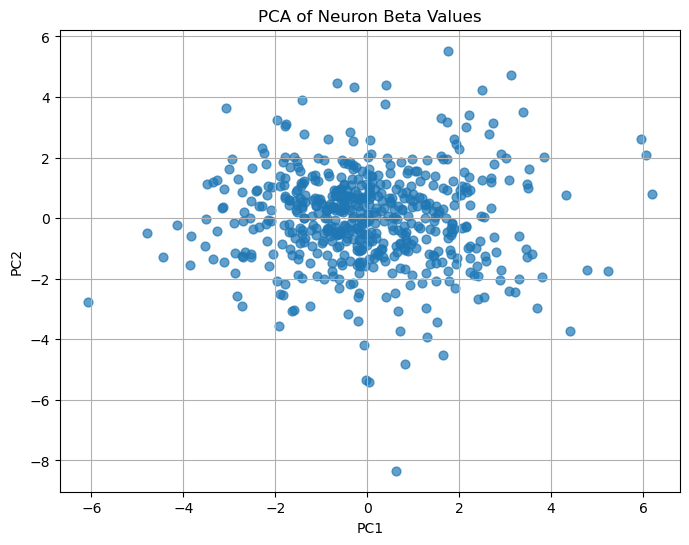

Explained variance ratio (PC1, PC2): [0.41520129 0.34506605]
PCA Loadings:
                         PC1       PC2
value_beta         -0.009552 -0.285114
state_1_beta       -0.462419 -0.302602
state_2_beta        0.539350 -0.105343
state_3_beta       -0.128737  0.603496
state_value_1_beta  0.417821  0.288004
state_value_2_beta -0.533216  0.082506
state_value_3_beta  0.140400 -0.601734


In [311]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select the 8 beta columns for each neuron
beta_cols = [col for col in neuron_profile.columns if col.endswith('_beta')][1:] # Exclude the intercept
X_beta = neuron_profile[beta_cols].values

# Standardize the beta values
scaler = StandardScaler()
X_beta_scaled = scaler.fit_transform(X_beta)

# PCA to 2D for visualization
pca = PCA(n_components=2)
X_beta_pca = pca.fit_transform(X_beta_scaled)

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(X_beta_pca[:, 0], X_beta_pca[:, 1], s=40, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Neuron Beta Values')
plt.grid(True)
plt.show()

# Show explained variance ratio for each principal component
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

# Show PCA loadings (contribution of each beta to each PC)
loadings = pd.DataFrame(
    pca.components_.T,
    index=beta_cols,
    columns=['PC1', 'PC2']
)
print("PCA Loadings:")
print(loadings)

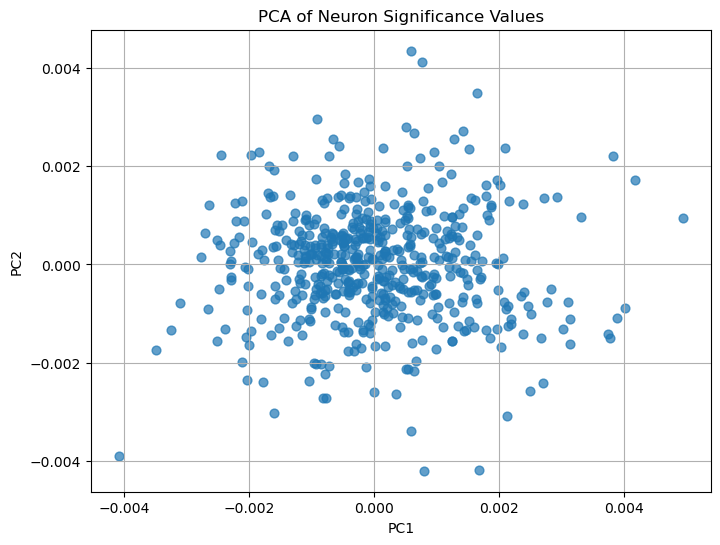

Explained variance ratio (PC1, PC2): [0.51751776 0.38969888]
PCA Loadings:
                         PC1       PC2
value_beta         -0.001776 -0.073081
state_1_beta       -0.475970 -0.551484
state_2_beta        0.791287 -0.031449
state_3_beta       -0.298098  0.796661
state_value_1_beta  0.113445  0.128618
state_value_2_beta -0.197154 -0.006033
state_value_3_beta  0.081932 -0.195672


In [312]:
def weighted_coeff(row):
    return {
        col: (1 - max(row[f'{col}_pval'], 0.99)) * row[f'{col}_beta']
        for col in tuning_cols
    }

weighted_df = neuron_profile.apply(weighted_coeff, axis=1, result_type='expand')

pca = PCA(n_components=2)
pca_scores = pca.fit_transform(weighted_df)

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_scores[:, 0], pca_scores[:, 1], s=40, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Neuron Significance Values')
plt.grid(True)
plt.show()

# Show explained variance ratio for each principal component
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

# Show PCA loadings (contribution of each beta to each PC)
loadings = pd.DataFrame(
    pca.components_.T,
    index=beta_cols,
    columns=['PC1', 'PC2']
)

print("PCA Loadings:")
print(loadings)


In [313]:
neuron_profile = get_coding_type(neuron_profile, p_thresh=0.05)

In [314]:
coding_counts = neuron_profile['coding_type'].value_counts()
print(coding_counts)

coding_type
none           265
state_value    147
value           78
state           56
Name: count, dtype: int64


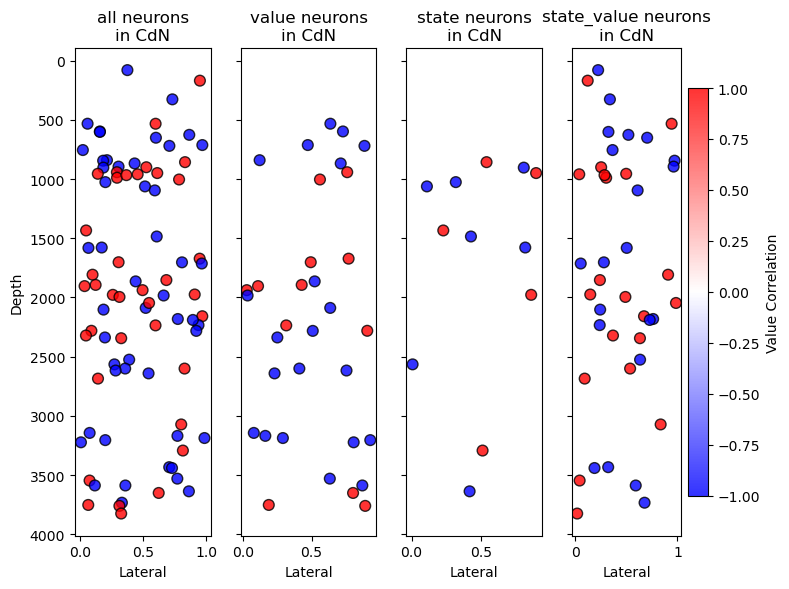

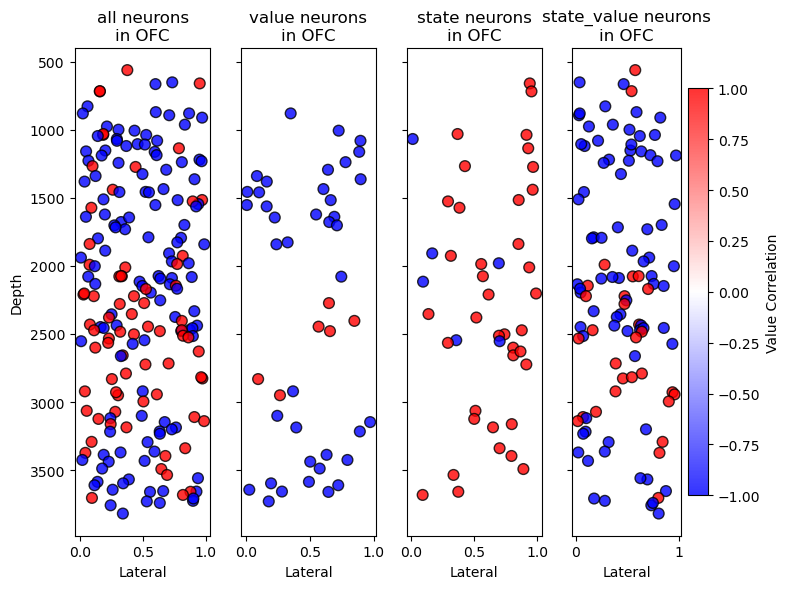

In [321]:
# Apply get_value_correlation to each row of valid_neurons to create a new column
neuron_profile['value_correlation'] = neuron_profile.apply(get_value_correlation, axis=1)
brain_area = 1  # '0' for CdN, '1' for OFC

plot_neuron_locations(neuron_profile, brain_area=0, color_col='value_correlation') # CdN
plot_neuron_locations(neuron_profile, brain_area=1, color_col='value_correlation') # OFC

C:\Users\krgyk\AppData\Local\Temp\ipykernel_6508\767355449.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neurons2plot['rel_depth'] = neurons2plot['depth'] - target_depth
C:\Users\krgyk\AppData\Local\Temp\ipykernel_6508\767355449.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neurons2plot['depth_bin'] = pd.cut(neurons2plot['rel_depth'], bins=depth_bins)
C:\Users\krgyk\AppData\Local\Temp\ipykernel_6508\767355449.py:17: FutureWarning: The default of observed=False is deprecated and will be changed 

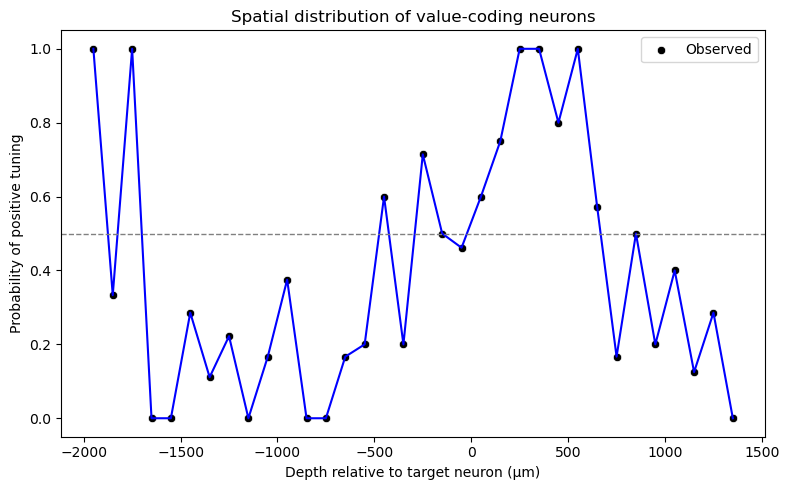

In [316]:
correlation2plot = 1  # 1 for positive, -1 for negative
brain_area = 1  # '0' for CdN, '1' for OFC
mask = (neuron_profile['coding_type'] != 'none') & (neuron_profile['brain_area'] == brain_area)
neurons2plot = neuron_profile[mask]

target_depth = neurons2plot[neurons2plot['value_correlation'] == correlation2plot]['depth'].median()
neurons2plot['rel_depth'] = neurons2plot['depth'] - target_depth

bin_width = 100
min_depth = neurons2plot['rel_depth'].min()
max_depth = neurons2plot['rel_depth'].max()
depth_bins = np.arange(np.floor(min_depth / bin_width) * bin_width,
                       np.ceil(max_depth / bin_width) * bin_width + bin_width,
                       bin_width)
neurons2plot['depth_bin'] = pd.cut(neurons2plot['rel_depth'], bins=depth_bins)

prob_by_bin = neurons2plot.groupby('depth_bin')['value_correlation'].apply(
    lambda x: (x == 1).mean()
)

# Convert bin labels to bin centers for plotting
bin_centers = [interval.mid for interval in prob_by_bin.index]

# Plot scatter + smooth curve
plt.figure(figsize=(8, 5))
sns.scatterplot(x=bin_centers, y=prob_by_bin.values, color='black', label='Observed')
sns.lineplot(x=bin_centers, y=prob_by_bin.values, color='blue')

plt.xlabel('Depth relative to target neuron (μm)')
plt.ylabel('Probability of positive tuning')
plt.title('Spatial distribution of value-coding neurons')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\krgyk\AppData\Local\Temp\ipykernel_6508\4167341403.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bin = neurons2plot.groupby('depth_bin')['value_correlation'].apply(
C:\Users\krgyk\AppData\Local\Temp\ipykernel_6508\4167341403.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bin = neurons2plot.groupby('depth_bin')['value_correlation'].apply(
C:\Users\krgyk\AppData\Local\Temp\ipykernel_6508\4167341403.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

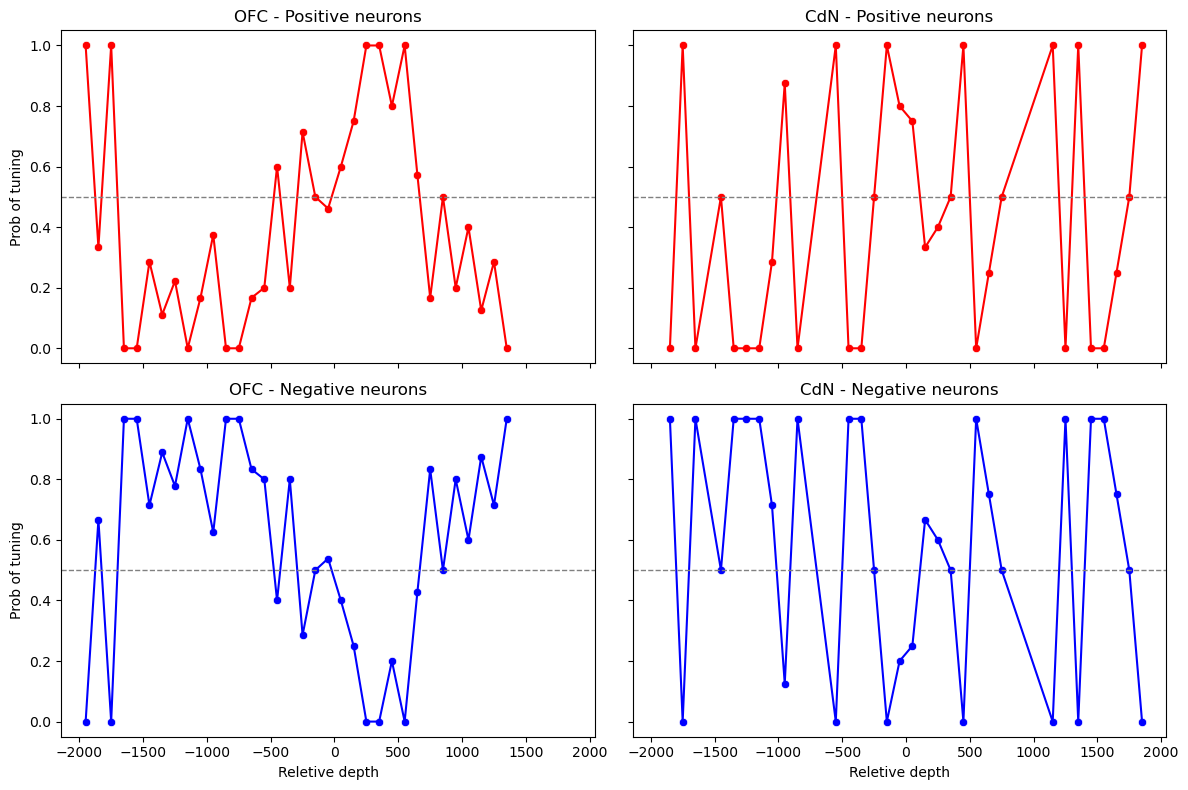

In [317]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
bin_width = 100

for i, brain_area in enumerate([1, 0]):  # OFC (left), CdN (right)
    for j, correlation2plot in enumerate([1, -1]):  # Positive (top), Negative (bottom)
        
        # Filter neurons
        mask = (neuron_profile['coding_type'] != 'none') & \
               (neuron_profile['brain_area'] == brain_area)
        neurons2plot = neuron_profile[mask].copy()
        
        # Select target depth
        target_depth = neurons2plot[neurons2plot['value_correlation'] == 1]['depth'].median()
        neurons2plot['rel_depth'] = neurons2plot['depth'] - target_depth

        # Bin depth
        min_depth = neurons2plot['rel_depth'].min()
        max_depth = neurons2plot['rel_depth'].max()
        depth_bins = np.arange(np.floor(min_depth / bin_width) * bin_width,
                                np.ceil(max_depth / bin_width) * bin_width + bin_width,
                                bin_width)
        neurons2plot['depth_bin'] = pd.cut(neurons2plot['rel_depth'], bins=depth_bins)

        # Compute probability
        prob_by_bin = neurons2plot.groupby('depth_bin')['value_correlation'].apply(
            lambda x: (x == correlation2plot).mean()
        )
        bin_centers = [interval.mid for interval in prob_by_bin.index]

        # Plot
        ax = axes[j, i]
        correlation_palette = {1: 'red', -1: 'blue'}
        color = correlation_palette[correlation2plot]  # select the color for this subplot
        sns.scatterplot(x=bin_centers, y=prob_by_bin.values, color=color, ax=ax)
        sns.lineplot(x=bin_centers, y=prob_by_bin.values, color=color, ax=ax)

        # Labels
        area_label = {0: 'CdN', 1: 'OFC'}[brain_area]
        corr_label = {-1: 'Negative', 1: 'Positive'}[correlation2plot]
        ax.set_title(f'{area_label} - {corr_label} neurons')
        ax.axhline(0.5, color='gray', linestyle='--', linewidth=1)
        ax.set_xlabel('Reletive depth')
        ax.set_ylabel('Prob of tuning')

plt.tight_layout()
plt.show()

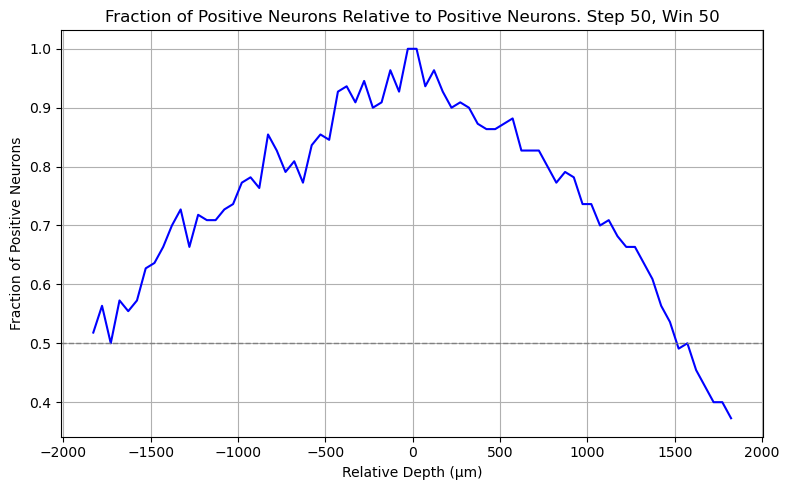

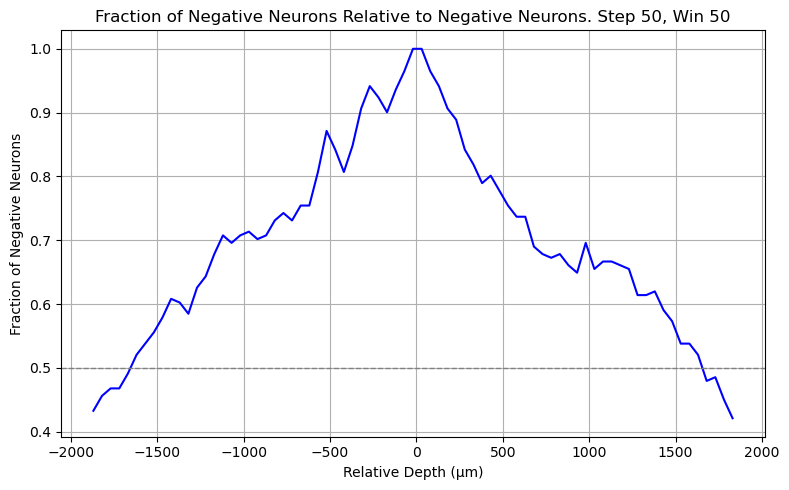

In [318]:
plot_neuron_centric_density(neuron_profile, tarkget_neurons=1, reference_filter=1, step_size=50, win_size=50)  # positive around positive
plot_neuron_centric_density(neuron_profile, tarkget_neurons=-1, reference_filter=-1, step_size=50, win_size=50)  # positive around positive

In [319]:
neuron_profile = extract_neuron_profile(file_path)

NameError: name 'extract_neuron_profile' is not defined